# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import *

import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout,GlobalMaxPooling1D
from keras.src.utils.np_utils import to_categorical
from keras.models import Sequential

np.random.seed(0)
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preprocessing Data**

In [3]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CIDDS-001/reduced_cidds_001_normal_portscan_pingscan.csv")
df1 = df1.rename(columns={'class': 'label'})

df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-002/reduced_cidds_002_normal_scan.csv')

df = pd.concat([df1, df2], ignore_index=True)
df

<ipython-input-3-b0948c52b01b>:1: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CIDDS-001/reduced_cidds_001_normal_portscan_pingscan.csv")
<ipython-input-3-b0948c52b01b>:4: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-002/reduced_cidds_002_normal_scan.csv')


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,label,attackType,attackID,attackDescription
0,2017-03-23 13:40:24.221,0.134,TCP,10305_148,443,192.168.210.5,50210.0,5,449,1,.AP.S.,32,normal,---,---,---
1,2017-03-22 16:15:56.404,0.000,TCP,10001_230,443,192.168.220.15,44214.0,1,462,1,.AP...,0,normal,---,---,---
2,2017-04-18 10:09:51.492,0.508,TCP,16796_188,443,192.168.200.4,42941.0,7,6203,1,.AP.S.,32,normal,---,---,---
3,2017-03-15 11:23:38.445,0.095,TCP,10068_2,443,192.168.220.8,58538.0,5,1246,1,.AP...,32,normal,---,---,---
4,2017-03-23 16:59:50.774,0.000,TCP,15306_50,80,192.168.220.13,41670.0,1,66,1,.A....,32,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231831,2017-08-08 19:52:49.297,0.000,TCP,192.168.210.56,5907,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231832,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,3,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231833,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,32778,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231834,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,8800,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2


In [4]:
df.select_dtypes(include=['object']).columns

Index(['Date first seen', 'Proto', 'Src IP Addr', 'Dst IP Addr', 'Bytes',
       'Flags', 'label', 'attackType', 'attackID', 'attackDescription'],
      dtype='object')

In [5]:
df.isna().sum()

Date first seen      0
Duration             0
Proto                0
Src IP Addr          0
Src Pt               0
Dst IP Addr          0
Dst Pt               0
Packets              0
Bytes                0
Flows                0
Flags                0
Tos                  0
label                0
attackType           0
attackID             0
attackDescription    0
dtype: int64

In [6]:
df.duplicated().sum()

36568

In [7]:
df.drop_duplicates(inplace = True)
df.shape

(5195268, 16)

In [8]:
df['Proto'].value_counts()

TCP      4386603
UDP       744306
ICMP       64206
IGMP         153
Name: Proto, dtype: int64

In [9]:
df['Bytes'].astype('str').value_counts()

      66    1236773
54           416949
58           211005
      54     160471
      55     139482
             ...   
   54222          1
   81674          1
   19389          1
   35240          1
20573             1
Name: Bytes, Length: 84192, dtype: int64

In [10]:
df['Flags'].value_counts()

.A....    1570689
......     808665
.AP...     700075
.AP.S.     550334
.A...F     386492
.A.R..     238101
....S.     225951
.AP..F     170048
.A..S.     142218
.AP.SF     136838
.....F     112958
...R..      58520
.APRSF      34740
.APR.F      32791
.A..SF       6646
...RS.       6176
.A.R.F       5660
.APRS.       4334
.APR..       3703
.A.RS.        230
.A.RSF         99
Name: Flags, dtype: int64

In [11]:
df['label'].value_counts()

normal      4378392
attacker     511295
victim       305581
Name: label, dtype: int64

In [12]:
df['attackType'].value_counts()

---         4378392
scan         534561
portScan     276234
pingScan       6081
Name: attackType, dtype: int64

In [13]:
df['attackID'].value_counts()

---    4378392
11       54703
17       53283
20       46916
32       43312
        ...   
57         522
58         509
65         371
66         359
69         359
Name: attackID, Length: 68, dtype: int64

In [14]:
df['attackDescription'].value_counts()

---                           4382402
nmap args: -sS -T 2            185630
nmap args: -sF -T 3            109847
nmap args: -sS -T 1            107124
nmap args: -sS -T 3             93085
nmap args: -sU -T 2             86393
nmap args: -sF -T 2             63665
nmap args: -sA -T 3             50084
nmap args: -sF -T 1             34707
nmap args: -sU -T 3             27749
nmap args: -sU -T 1             20713
nmap args: -sA -T 1             17027
nmap args: -sA -T 2              4436
nmap args: -sU -T 0              4398
nmap args: -n -sP -PE -T 2       3731
nmap args: -n -sP -PE -T 1       3440
nmap args: -n -sP -PE -T 3        837
Name: attackDescription, dtype: int64

### Rename label

In [15]:
df['label'] = df['label'].replace(['normal'], '0_normal')
df['label'].value_counts()

0_normal    4378392
attacker     511295
victim       305581
Name: label, dtype: int64

In [16]:
df['label'] = df['label'].replace(['attacker', 'victim'], 'attack')
df['label'].value_counts()

0_normal    4378392
attack       816876
Name: label, dtype: int64

In [17]:
df['attackDescription'] = df['attackDescription'].replace(['---'], 'normal')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sS -T 1', 'nmap args: -sS -T 2', 'nmap args: -sS -T 3'], 'SYN Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sF -T 1', 'nmap args: -sF -T 2', 'nmap args: -sF -T 3'], 'FIN Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sU -T 0 ', 'nmap args: -sU -T 1', 'nmap args: -sU -T 2', 'nmap args: -sU -T 3' ], 'UDP Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sA -T 1', 'nmap args: -sA -T 2', 'nmap args: -sA -T 3'], 'ACK Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -n -sP -PE -T 1', 'nmap args: -n -sP -PE -T 2', 'nmap args: -n -sP -PE -T 3'], 'Ping Scan')
df['attackDescription'].value_counts()

normal       4382402
SYN Scan      385839
FIN Scan      208219
UDP Scan      139253
ACK Scan       71547
Ping Scan       8008
Name: attackDescription, dtype: int64

In [18]:
df['attackDescription'] = df['attackDescription'].replace(['SYN Scan', 'FIN Scan', 'ACK Scan'], 'TCP')
df['attackDescription'] = df['attackDescription'].replace(['UDP Scan'], 'UDP')
df['attackDescription'] = df['attackDescription'].replace(['Ping Scan'], 'ICMP')
df['attackDescription'].value_counts()

normal    4382402
TCP        665605
UDP        139253
ICMP         8008
Name: attackDescription, dtype: int64

### Drop features

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5195268 entries, 0 to 5231835
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date first seen    object 
 1   Duration           float64
 2   Proto              object 
 3   Src IP Addr        object 
 4   Src Pt             int64  
 5   Dst IP Addr        object 
 6   Dst Pt             float64
 7   Packets            int64  
 8   Bytes              object 
 9   Flows              int64  
 10  Flags              object 
 11  Tos                int64  
 12  label              object 
 13  attackType         object 
 14  attackID           object 
 15  attackDescription  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 673.8+ MB


In [20]:
df = df.drop(columns = ['Date first seen', 'Src IP Addr', 'Dst IP Addr',  'attackType', 'attackID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5195268 entries, 0 to 5231835
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Duration           float64
 1   Proto              object 
 2   Src Pt             int64  
 3   Dst Pt             float64
 4   Packets            int64  
 5   Bytes              object 
 6   Flows              int64  
 7   Flags              object 
 8   Tos                int64  
 9   label              object 
 10  attackDescription  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 475.6+ MB


In [21]:
df = df.drop(df.loc[df['attackDescription'] == 'normal'].sample(frac = 0.8).index)

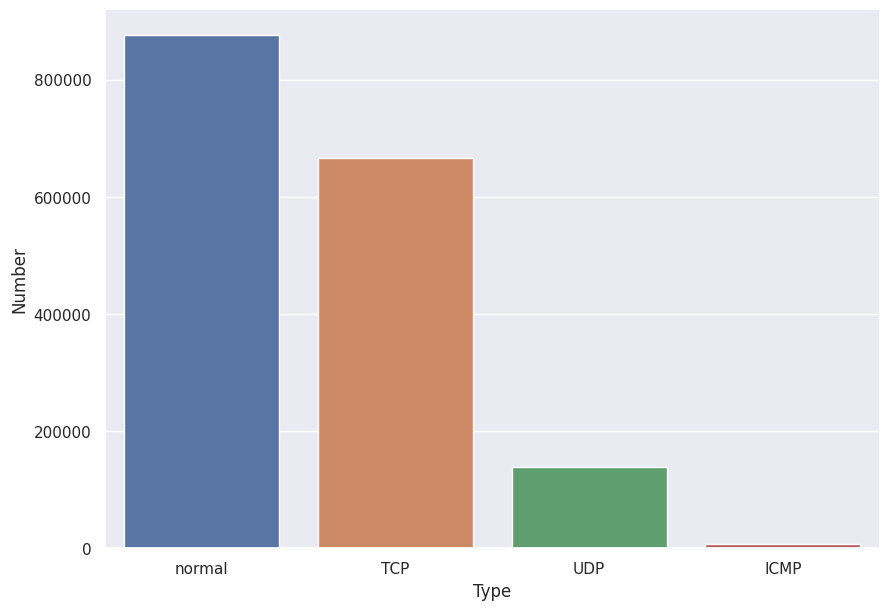

In [22]:
sns.set(rc = {'figure.figsize' : (10, 7)})
ax = sns.countplot(x = 'attackDescription', data = df)
ax.set(xlabel = 'Type', ylabel = 'Number')
plt.show()

### Other features

In [23]:
def convert_to_int(value):
    try:
        if 'M' in str(value):
            result = int(float(value[:-2])*10**6)
        else:
            result = int(value)
    except (ValueError, TypeError):
        print(value)
        result = 0
    return result

In [24]:
df['Bytes'] = df['Bytes'].apply(convert_to_int)
df['Bytes'].value_counts()

54       441451
66       269637
58       218650
42       110075
70        38081
          ...  
37744         1
15772         1
16351         1
9182          1
20573         1
Name: Bytes, Length: 28332, dtype: int64

In [25]:
label_encoder = LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])
label_encoder.classes_

array(['0_normal', 'attack'], dtype=object)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Duration           1689346 non-null  float64
 1   Proto              1689346 non-null  object 
 2   Src Pt             1689346 non-null  int64  
 3   Dst Pt             1689346 non-null  float64
 4   Packets            1689346 non-null  int64  
 5   Bytes              1689346 non-null  int64  
 6   Flows              1689346 non-null  int64  
 7   Flags              1689346 non-null  object 
 8   Tos                1689346 non-null  int64  
 9   label              1689346 non-null  int64  
 10  attackDescription  1689346 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 154.7+ MB


In [27]:
features_to_exclude = ['label', 'Proto']
y = df.loc[:, features_to_exclude]
X = df.drop(features_to_exclude, axis=1)

print(X.shape, y.shape)

(1689346, 9) (1689346, 2)


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Duration           1689346 non-null  float64
 1   Src Pt             1689346 non-null  int64  
 2   Dst Pt             1689346 non-null  float64
 3   Packets            1689346 non-null  int64  
 4   Bytes              1689346 non-null  int64  
 5   Flows              1689346 non-null  int64  
 6   Flags              1689346 non-null  object 
 7   Tos                1689346 non-null  int64  
 8   attackDescription  1689346 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 128.9+ MB


In [29]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1689346 non-null  int64 
 1   Proto   1689346 non-null  object
dtypes: int64(1), object(1)
memory usage: 38.7+ MB


### One hot encoding

In [30]:
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 32 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Duration                  1689346 non-null  float64
 1   Src Pt                    1689346 non-null  int64  
 2   Dst Pt                    1689346 non-null  float64
 3   Packets                   1689346 non-null  int64  
 4   Bytes                     1689346 non-null  int64  
 5   Flows                     1689346 non-null  int64  
 6   Tos                       1689346 non-null  int64  
 7   Flags_......              1689346 non-null  uint8  
 8   Flags_.....F              1689346 non-null  uint8  
 9   Flags_....S.              1689346 non-null  uint8  
 10  Flags_...R..              1689346 non-null  uint8  
 11  Flags_...RS.              1689346 non-null  uint8  
 12  Flags_.A....              1689346 non-null  uint8  
 13  Flags_.A...F              1

In [31]:
final_df = pd.concat([X, y], axis=1)
final_df

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
3,0.095,443,58538.0,5,1246,1,32,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
15,0.000,57315,443.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
18,0.021,60025,80.0,2,108,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
21,0.000,63957,53.0,1,82,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
26,0.032,40285,80.0,3,624,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231831,0.000,5907,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231832,0.000,3,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231833,0.000,32778,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231834,0.000,8800,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP


### Train-Test split

In [32]:
train, test = train_test_split(final_df, test_size=0.3, random_state=42)
train

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
2229571,0.000,443,60382.0,1,66,1,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
3279170,0.000,80,55252.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
2212238,0.021,443,54397.0,3,193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,TCP
4756011,0.000,787,50342.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
2265158,0.045,53,36795.0,2,380,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294916,0.026,62375,443.0,4,568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
4937499,6.410,0,3.3,5,350,1,192,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,ICMP
658411,0.000,53,57615.0,1,91,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
2931232,0.000,46755,4129.0,1,58,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP


In [33]:
# @title drop tcp and icmp of train

train = train[(train['attackDescription_TCP'] != 1)]
train.shape

(716847, 34)

In [34]:
train = train[(train['attackDescription_ICMP'] != 1)]
train.shape

(711232, 34)

In [35]:
train["Proto"].unique()

array(['TCP  ', 'UDP  ', 'ICMP ', 'IGMP '], dtype=object)

In [36]:
# @title drop tcp and icmp protocol

train = train.loc[~((train["Proto"] == 'TCP ') & (train["label"] == 1))]
train.shape

(711232, 34)

In [37]:
train = train.loc[~((train["Proto"] == 'ICMP ') & (train["label"] == 1))]
train.shape

(685691, 34)

In [38]:
train = train.reset_index(drop=True)
train

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
0,0.000,443,60382.0,1,66,1,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
1,0.000,80,55252.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
2,0.021,443,54397.0,3,193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,TCP
3,0.045,53,36795.0,2,380,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
4,0.000,52253,80.0,1,66,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685686,0.000,445,59534.0,1,108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
685687,0.000,80,59642.0,1,66,1,32,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
685688,0.026,62375,443.0,4,568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
685689,0.000,53,57615.0,1,91,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP


In [39]:
test = test.reset_index(drop=True)

In [40]:
train = train.drop("Proto", axis=1)
test = test.drop("Proto", axis=1)

# **MODEL**

## **STEP 1**

In [41]:
X_train = train.iloc[:, :-5]
X_test = test.iloc[:, :-5]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685691 entries, 0 to 685690
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Duration      685691 non-null  float64
 1   Src Pt        685691 non-null  int64  
 2   Dst Pt        685691 non-null  float64
 3   Packets       685691 non-null  int64  
 4   Bytes         685691 non-null  int64  
 5   Flows         685691 non-null  int64  
 6   Tos           685691 non-null  int64  
 7   Flags_......  685691 non-null  uint8  
 8   Flags_.....F  685691 non-null  uint8  
 9   Flags_....S.  685691 non-null  uint8  
 10  Flags_...R..  685691 non-null  uint8  
 11  Flags_...RS.  685691 non-null  uint8  
 12  Flags_.A....  685691 non-null  uint8  
 13  Flags_.A...F  685691 non-null  uint8  
 14  Flags_.A..S.  685691 non-null  uint8  
 15  Flags_.A..SF  685691 non-null  uint8  
 16  Flags_.A.R..  685691 non-null  uint8  
 17  Flags_.A.R.F  685691 non-null  uint8  
 18  Flag

### Round 1

In [42]:
#Detect udp

rf = RandomForestClassifier()
clf_1 = rf.fit(X_train, train['attackDescription_UDP'])

In [43]:
start_time = time.time()
y_pred_1 = clf_1.predict(X_test)
end_time = time.time()
execution_time_r1 = end_time - start_time

In [44]:
cm = confusion_matrix(test['attackDescription_UDP'], y_pred_1)

acc = accuracy_score(test['attackDescription_UDP'], y_pred_1)
ppv = precision_score(test['attackDescription_UDP'], y_pred_1, average='macro')
f1 = f1_score(test['attackDescription_UDP'], y_pred_1, average='macro')
tpr = recall_score(test['attackDescription_UDP'], y_pred_1, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(test['attackDescription_UDP'], y_pred_1)
mcc = matthews_corrcoef(test['attackDescription_UDP'], y_pred_1)
# udr = sum(y_pred_1[Service_Scan_test_index] == test['attackDescription_TCP'][Service_Scan_test_index]) / len(Service_Scan_test_index)

# model_pred['Tabnet'] = y_pred_1
# model_acc['Tabnet'] = acc
# model_ppv['Tabnet'] = ppv
# model_f1['Tabnet'] = f1
# model_tpr['Tabnet'] = tpr
# model_fpr['Tabnet'] = fpr
# model_auc['Tabnet'] = auc
# model_mcc['Tabnet'] = mcc
# model_udr['Tabnet'] = udr

print('Scores of round 1:')
# print(f'\tUDR: {udr} ({sum(y_pred_1[Service_Scan_test_index] == test['attackDescription_TCP'][Service_Scan_test_index])} / {len(Service_Scan_test_index)})')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of round 1:
	ACC: 0.9350399760065035
	PPV: 0.7804639382700792
	TPR: 0.851315408181337
	F1 : 0.8105886839698215
	AUC: 0.8513154081813369
	MCC: 0.6277939246392821
	FPR: 0.0483275854279303


In [45]:
print(confusion_matrix(test['attackDescription_UDP'], y_pred_1))

[[442344  22463]
 [ 10459  31538]]


In [46]:
print(classification_report(test['attackDescription_UDP'], y_pred_1))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    464807
           1       0.58      0.75      0.66     41997

    accuracy                           0.94    506804
   macro avg       0.78      0.85      0.81    506804
weighted avg       0.94      0.94      0.94    506804



In [47]:
remain_indices_1 = test.index[np.where(y_pred_1 == 0)[0]]
print(remain_indices_1)

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     11,
            ...
            506792, 506793, 506794, 506795, 506796, 506798, 506799, 506800,
            506801, 506803],
           dtype='int64', length=452803)


In [48]:
udp_pred = test.index[np.where(y_pred_1 == 1)[0]]
print(udp_pred)

Int64Index([     0,     10,     14,     29,     38,     48,     60,     63,
                77,     88,
            ...
            506731, 506732, 506736, 506753, 506757, 506761, 506766, 506791,
            506797, 506802],
           dtype='int64', length=54001)


## **STEP 2**

## Outlier

In [49]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=15232b148fe6b64c59bb30def45623c1959dc6dc90ff14282d9376411880de31
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


### LOF

In [50]:
train_lof = train[(train['label'] == 0)]
X_train_lof = train_lof.iloc[:, :-5]

In [51]:
X_test_2 = X_test.loc[remain_indices_1]
test_2 = test.loc[remain_indices_1]

In [52]:
# # train an LOF detector
# from pyod.models.ecod import ECOD
# from pyod.models.abod import ABOD
# from pyod.models.alad import ALAD
# from pyod.models.anogan import AnoGAN
# from pyod.models.rod import ROD
# from pyod.models.lof import LOF
# from pyod.models.lscp import LSCP
# from pyod.models.ocsvm import OCSVM
# from pyod.models.cblof import CBLOF
# from pyod.models.knn import KNN
# from pyod.models.lunar import LUNAR
# from pyod.models.inne import INNE
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.iforest import IForest

# # model_1 = OCSVM()
# # model_2 = CBLOF()
# # model_3 = KNN()

# clf = LOF( contamination=0.05)
# clf.fit(X_train_lof)

# # get outlier scores
# y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
# y_test_scores = clf.decision_function(X_test_2)  # predict raw outlier scores on test
# print(f"Train_score: {y_train_scores.mean()}")
# print(f"Test_score: {y_test_scores.mean()}")

In [53]:
from joblib import dump, load

# save the model
# dump(clf_lof, 'clf_lof_tcp_icmp.joblib')
# load the model
clf_lof = load('/content/drive/MyDrive/Colab Notebooks/data/CIDDS Data/clf_lof_tcp.joblib')

In [54]:
start_time = time.time()

y_pred_lof = clf_lof.predict(X_test_2)

end_time = time.time()
execution_time_lof = end_time - start_time

pd.DataFrame(y_pred_lof).value_counts()

0    277017
1    175786
dtype: int64

In [55]:
test_2['attackDescription_normal'].value_counts()

1    262427
0    190376
Name: attackDescription_normal, dtype: int64

In [56]:
true_abnormal_1 = test_2['attackDescription_normal'].copy()
true_abnormal_1 = true_abnormal_1.replace({0: 1, 1: 0})
true_abnormal_1.value_counts()

0    262427
1    190376
Name: attackDescription_normal, dtype: int64

In [57]:
cm = confusion_matrix(true_abnormal_1, y_pred_lof)

acc = accuracy_score(true_abnormal_1, y_pred_lof)
ppv = precision_score(true_abnormal_1, y_pred_lof, average='macro')
f1 = f1_score(true_abnormal_1, y_pred_lof, average='macro')
tpr = recall_score(true_abnormal_1, y_pred_lof, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(true_abnormal_1, y_pred_lof)
mcc = matthews_corrcoef(true_abnormal_1, y_pred_lof)

print('Scores of outlier:')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of outlier:
	ACC: 0.9100756841275345
	PPV: 0.9129272776907931
	TPR: 0.9024793151268178
	F1 : 0.9066582164448389
	AUC: 0.9024793151268178
	MCC: 0.8153396541863315
	FPR: 0.04978146303543462


In [58]:
print(confusion_matrix(true_abnormal_1, y_pred_lof))

[[249363  13064]
 [ 27654 162722]]


In [59]:
print(classification_report(true_abnormal_1, y_pred_lof))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92    262427
           1       0.93      0.85      0.89    190376

    accuracy                           0.91    452803
   macro avg       0.91      0.90      0.91    452803
weighted avg       0.91      0.91      0.91    452803



In [60]:
remain_indices_2 = test_2.index[np.where(y_pred_lof == 0)[0]]
print(remain_indices_2)

Int64Index([     4,      5,      6,      7,      8,     11,     12,     13,
                18,     19,
            ...
            506784, 506786, 506788, 506789, 506790, 506792, 506793, 506795,
            506796, 506800],
           dtype='int64', length=277017)


In [61]:
novelty_pred_lof = true_abnormal_1.index[np.where(y_pred_lof == 1)[0]]

In [62]:
print(novelty_pred_lof)

Int64Index([     1,      2,      3,      9,     15,     16,     17,     23,
                25,     27,
            ...
            506780, 506782, 506783, 506785, 506787, 506794, 506798, 506799,
            506801, 506803],
           dtype='int64', length=175786)


### INNE

In [63]:
train_inne = train[(train['label'] == 0)]
X_train_inne = train_inne.iloc[:, :-5]

In [64]:
X_test_3 = X_test.loc[remain_indices_2]
test_3 = test.loc[remain_indices_2]

In [65]:
# # train with INNE detector
# from pyod.models.ecod import ECOD
# from pyod.models.abod import ABOD
# from pyod.models.alad import ALAD
# from pyod.models.anogan import AnoGAN
# from pyod.models.rod import ROD
# from pyod.models.lof import LOF
# from pyod.models.lscp import LSCP
# from pyod.models.ocsvm import OCSVM
# from pyod.models.cblof import CBLOF
# from pyod.models.knn import KNN
# from pyod.models.lunar import LUNAR
# from pyod.models.inne import INNE
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.iforest import IForest

# # model_1 = OCSVM()
# # model_2 = CBLOF()
# # model_3 = KNN()

# clf = INNE( contamination=0.05)
# clf.fit(X_train_inne)

# # get outlier scores
# y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
# y_test_scores = clf.decision_function(X_test_3)  # predict raw outlier scores on test
# print(f"Train_score: {y_train_scores.mean()}")
# print(f"Test_score: {y_test_scores.mean()}")

In [66]:
from joblib import dump, load

# save the model
# dump(clf_inne, 'clf_inne_tcp_icmp.joblib')
# load the model
clf_inne = load('/content/drive/MyDrive/Colab Notebooks/data/CIDDS Data/clf_inne_tcp.joblib')

In [67]:
start_time = time.time()

y_pred_inne = clf_inne.predict(X_test_3)

end_time = time.time()
execution_time_inne = end_time - start_time

pd.DataFrame(y_pred_inne).value_counts()

0    251093
1     25924
dtype: int64

In [68]:
test_3['attackDescription_normal'].value_counts()

1    249363
0     27654
Name: attackDescription_normal, dtype: int64

In [69]:
true_abnormal_2 = test_3['attackDescription_normal'].copy()
true_abnormal_2 = true_abnormal_2.replace({0: 1, 1: 0})
true_abnormal_2.value_counts()


0    249363
1     27654
Name: attackDescription_normal, dtype: int64

In [70]:
cm = confusion_matrix(true_abnormal_2, y_pred_inne)

acc = accuracy_score(true_abnormal_2, y_pred_inne)
ppv = precision_score(true_abnormal_2, y_pred_inne, average='macro')
f1 = f1_score(true_abnormal_2, y_pred_inne, average='macro')
tpr = recall_score(true_abnormal_2, y_pred_inne, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(true_abnormal_2, y_pred_inne)
mcc = matthews_corrcoef(true_abnormal_2, y_pred_inne)

print('Scores of outlier:')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of outlier:
	ACC: 0.9028146287050975
	PPV: 0.7285318170811863
	TPR: 0.7157214438757931
	F1 : 0.7218613494104038
	AUC: 0.7157214438757931
	MCC: 0.4440685242271158
	FPR: 0.05051270637584566


In [71]:
print(confusion_matrix(true_abnormal_2, y_pred_inne))

[[236767  12596]
 [ 14326  13328]]


In [72]:
print(classification_report(true_abnormal_2, y_pred_inne))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95    249363
           1       0.51      0.48      0.50     27654

    accuracy                           0.90    277017
   macro avg       0.73      0.72      0.72    277017
weighted avg       0.90      0.90      0.90    277017



In [73]:
novelty_pred_inne = true_abnormal_2.index[np.where(y_pred_inne == 1)[0]]
print(novelty_pred_inne)

Int64Index([    26,     31,     33,     45,     64,    122,    123,    135,
               148,    158,
            ...
            506580, 506674, 506684, 506706, 506724, 506730, 506770, 506775,
            506777, 506784],
           dtype='int64', length=25924)


In [74]:
novelty_pred = novelty_pred_lof.append(novelty_pred_inne)
novelty_pred

Int64Index([     1,      2,      3,      9,     15,     16,     17,     23,
                25,     27,
            ...
            506580, 506674, 506684, 506706, 506724, 506730, 506770, 506775,
            506777, 506784],
           dtype='int64', length=201710)

# **RESULT**

### Binary

In [75]:
y_pred = np.zeros_like(y_pred_1)

In [76]:
y_pred[novelty_pred]=1
y_pred[udp_pred]=1

pd.DataFrame(y_pred).value_counts()

1    255711
0    251093
dtype: int64

In [77]:
test_series_1 = pd.Series(test['attackDescription_TCP'])
test_series_1

0         0
1         1
2         1
3         1
4         0
         ..
506799    1
506800    0
506801    0
506802    0
506803    0
Name: attackDescription_TCP, Length: 506804, dtype: uint8

In [78]:
tcp_indices = np.where(test_series_1 == 1)[0]

In [79]:
test_series_2 = pd.Series(test['attackDescription_ICMP'])
test_series_2

0         0
1         0
2         0
3         0
4         0
         ..
506799    0
506800    0
506801    0
506802    0
506803    0
Name: attackDescription_ICMP, Length: 506804, dtype: uint8

In [80]:
icmp_indices = np.where(test_series_2 == 1)[0]

In [81]:
cm = confusion_matrix(test['label'], y_pred)

acc = accuracy_score(test['label'], y_pred)
ppv = precision_score(test['label'], y_pred, average='macro')
f1 = f1_score(test['label'], y_pred, average='macro')
tpr = recall_score(test['label'], y_pred, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(test['label'], y_pred)
mcc = matthews_corrcoef(test['label'], y_pred)

num_detec = sum(y_pred[tcp_indices] == 1)
num_TCP = sum(test['attackDescription_TCP'])
udr_tcp = num_detec / num_TCP

num_detec = sum(y_pred[icmp_indices] == 1)
num_ICMP = sum(test['attackDescription_ICMP'])
udr_icmp = num_detec / num_ICMP

# model_pred['Tabnet'] = y_pred
# model_acc['Tabnet'] = acc
# model_ppv['Tabnet'] = ppv
# model_f1['Tabnet'] = f1
# model_tpr['Tabnet'] = tpr
# model_fpr['Tabnet'] = fpr
# model_auc['Tabnet'] = auc
# model_mcc['Tabnet'] = mcc
# model_udr['Tabnet'] = udr

print('Scores of hybrid_model:')
print(f'\tUDR_TCP: {udr_tcp} ({num_detec} / {num_TCP})')
print(f'\tUDR_ICMP: {udr_icmp} ({num_detec} / {num_ICMP})')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of hybrid_model:
	UDR_TCP: 0.9290280626281827 (2317 / 199910)
	UDR_ICMP: 0.9682407020476389 (2317 / 2393)
	ACC: 0.9213857822748045
	PPV: 0.9215801364220821
	TPR: 0.9220614510220735
	F1 : 0.9213726328565465
	AUC: 0.9220614510220736
	MCC: 0.8436414501442843
	FPR: 0.09725659161535088


In [82]:
print(confusion_matrix(test['label'], y_pred))

[[236758  25507]
 [ 14335 230204]]


In [83]:
print(classification_report(test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92    262265
           1       0.90      0.94      0.92    244539

    accuracy                           0.92    506804
   macro avg       0.92      0.92      0.92    506804
weighted avg       0.92      0.92      0.92    506804



### Multiclass

In [84]:
y_pred_multi = np.zeros_like(y_pred_1)

In [85]:
y_pred_multi[novelty_pred]=1
y_pred_multi[udp_pred]=2

pd.DataFrame(y_pred_multi).value_counts()

0    251093
1    201710
2     54001
dtype: int64

In [86]:
label_multi = test['label'].copy()
label_multi[test['attackDescription_UDP'] == 1] = 2

In [87]:
print(confusion_matrix(label_multi, y_pred_multi))

[[236758  25430     77]
 [ 14273 165883  22386]
 [    62  10397  31538]]


In [88]:
print(classification_report(label_multi, y_pred_multi))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92    262265
           1       0.82      0.82      0.82    202542
           2       0.58      0.75      0.66     41997

    accuracy                           0.86    506804
   macro avg       0.78      0.82      0.80    506804
weighted avg       0.87      0.86      0.86    506804



### Time

In [89]:
print(f'{len(X_test)/(execution_time_r1)} ({len(X_test)} / {execution_time_r1})')

93544.78730886533 (506804 / 5.417768478393555)


In [90]:
print(f'{len(X_test_2)/(execution_time_lof)} ({len(X_test_2)} / {execution_time_lof})')

270.7034419314607 (452803 / 1672.6902205944061)


In [91]:
print(f'{len(X_test_3)/(execution_time_inne)} ({len(X_test_3)} / {execution_time_inne})')

7158.199993794837 (277017 / 38.69925403594971)


In [92]:
total_time = execution_time_r1+execution_time_lof+execution_time_inne
total_time

1716.8072431087494

In [93]:
# print(f'{len(test)/(total_time)} ({len(test)} / {total_time})')